## Spotify Query

In this notebook we perform some query on our property graph about Spotify. In particular the queries will be divided into three parts:
1. ***Example queries***: we perform two example queries where we show how it is possibile to use the new added information such as *record label* and *instruments*.
1. ***Italian tracks and Italian artists from 2017 to 2020:*** we perfom some queries about italian tracks and artists present in the TOP 100 Italy.
1. ***Italian tracks abroad:*** we want to discover if italian tracks are listened also outside Italy.

In [115]:
# Autoreload imports
%load_ext autoreload
%autoreload 2

# Import required libraries
from neo4j import GraphDatabase
import pandas as pd
from plotUtils import PlotUtils
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Connection to Neo4j

In [116]:
# Neo4J params class
class Neo4jParams:
  def __init__(self, user, psw, dbname, dbpsw, uri):
    self.user = user
    self.psw = psw
    self.dbname = dbname
    self.dbpsw = dbpsw
    self.uri = uri

In [117]:
#DB parameters
user = "neo4j"
psw = "neo4j"
dbname = "SpotifyDB"
dbpsw = "SpotifyDB"
uri = "bolt://localhost:7687"

params = Neo4jParams(user, psw, dbname, dbpsw, uri)

In [118]:
def getDriver():
    return GraphDatabase.driver(params.uri, auth=(params.user, params.dbpsw))

In [119]:
def executeQuery(query, **kwargs):
    # Connect to the DB and create a session
    driver = getDriver()
    session = driver.session()

    result = session.run(query, kwargs)

    resultDF = pd.DataFrame(result.values(), columns=result.keys())

    session.close()
    driver.close()

    return resultDF

## Plot utilities

In [120]:
TITLE_PAD = 30
TITLE_DIM = 30
XY_LABEL_PAD = 23
XY_LABEL_DIM = 21
XY_TICKS_DIM = 18
GRID_ALPHA = 0.2
FILL_ALPHA = 0.05
BAR_WIDTH = 0.95
LEGEND_LOC = "upper left"
LEGEND_LABEL_DIM = 15
COLOR_SCHEME = ["#1DB954", "#22577A", "#A03C78", "#C67ACE"]

FIG_SIZE = (18, 8)
FIG_BG_COLOR = None # "w"
FIG_DPI = 500
FIG_BBOX = "tight"
FIG_PAD = .3
FIG_FORMATS = ["png", "pdf"]

In [121]:
plotter = PlotUtils(
    options={
        "titlePad": TITLE_PAD,
        "titleDim": TITLE_DIM,
        "xyLabelPad": XY_LABEL_PAD,
        "xyLabelDim": XY_LABEL_DIM,
        "xyTicksDim": XY_TICKS_DIM,
        "gridAlpha": GRID_ALPHA,
        "fillAlpha": FILL_ALPHA,
        "barWidth": BAR_WIDTH,
        "legendLoc": LEGEND_LOC,
        "legendLabelDim": LEGEND_LABEL_DIM,
        "colorScheme": COLOR_SCHEME,
        "figSize": FIG_SIZE,
        "figBGColor": FIG_BG_COLOR,
        "figDPI": FIG_DPI,
        "figBBox": FIG_BBOX,
        "figPad": FIG_PAD,
        "figFormats": FIG_FORMATS,
    }
)

### Example Queries

##### Q1: Considering only records labels with more than 20 artists, show the top 10 record labels according to the averare position of the tracks released by artists of that specifc record label.

In [122]:
# Q1: Considering only records labels with more than 20 artists, show the top 10 record labels according to the averare position of the tracks released by artists of that specifc record label

executeQuery("""
    MATCH (r:RecordLabel)<-[:hasContractWith]-(a:Artist)
    WITH r,COUNT(DISTINCT a) AS numArtists
    WHERE numArtists > 20
    MATCH (r:RecordLabel)<-[:hasContractWith]-(a:Artist)-[:partecipateIn]->(t:Track)-[pos:isPositionedIn]->(ch:Chart)
    RETURN r.name as RecordLabel, AVG(pos.position) AS AvgPosition
    ORDER BY AvgPosition
    LIMIT 10
""")

,RecordLabel,AvgPosition
0,Virgin Records,45.520898
1,Def Jam Recordings,46.695923
2,Mercury Records,46.736621
3,Geffen Records,46.941477
4,Sony Music,47.250278
5,Spinnin' Records,47.605493
6,Republic Records,48.001249
7,Arista,48.099854
8,Island Records,48.476870
9,Warner Music Group,48.762100


###### Q1.2

In [123]:
executeQuery("""
    MATCH (l:RecordLabel)<-[:hasContractWith]-(a:Artist)-[:partecipateIn]->(t:Track)-[p:isPositionedIn]->(c:Chart)
    WITH l, avg(p.position) AS averagePosition
    MATCH (l)<-[:hasContractWith]-(a:Artist)-[:partecipateIn]->(t:Track)
    WITH l, averagePosition, count(distinct t) AS numTracks
    WITH l.name AS RecordLabel, averagePosition / numTracks AS QualityValue
    RETURN RecordLabel, QualityValue
    ORDER BY QualityValue asc
    LIMIT 10
""")

,RecordLabel,QualityValue
0,Universal Music Group,0.022028
1,Sony Music,0.039009
2,Columbia Records,0.042851
3,Atlantic Records,0.045361
4,Interscope Records,0.051307
5,Republic Records,0.055237
6,Def Jam Recordings,0.061442
7,Warner Music Group,0.071604
8,Capitol Records,0.078628
9,Epic Records,0.081389


##### Q2: Show the most common played instrument in rock groups

In [124]:
# Q2: Show the most common played instrument in rock groups

executeQuery("""
    MATCH (g:Genre{id:"rock"})<-[:hasGenre]-(a:Artist)<-[:isMemberOf]-(p:Person)-[:plays]->(i:Instrument)
    RETURN i.name as Instrument, COUNT(DISTINCT p) AS NumPlayers
    ORDER BY NumPlayers DESC
    LIMIT 3
""")

,Instrument,NumPlayers
0,guitar,159
1,voice,127
2,drum kit,67


### Italian Tracks and Italian Artists

#### Q3: Show technical features of Italian Tracks in the TOP 100 Italy through the years 2017-2020

In [125]:
#Q3: Show technical features of Italian Tracks in the TOP 100 Italy through the years 2017-2020

resultDF = executeQuery("""
    MATCH (c1:Country { id:"IT" })<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country { id:"IT" })
    RETURN
        ch.date.year as year,
        AVG(toInteger(t.explicit)) as explicit,
        AVG(t.danceability) as danceability,
        AVG(t.energy) as energy,
        AVG(t.mode) as mode,
        AVG(t.speechiness) as speechiness,
        AVG(t.acousticness) as acousticness,
        AVG(t.liveness) as liveness,
        AVG(t.valence) as valence 
""")

In [126]:
resultDF

,year,explicit,danceability,energy,mode,speechiness,acousticness,liveness,valence
0,2017,0.287141,0.693802,0.700226,0.565507,0.133392,0.166120,0.155275,0.499322
1,2020,0.547060,0.699990,0.703402,0.512141,0.142456,0.156802,0.156590,0.499865
2,2019,0.496583,0.706223,0.674506,0.532216,0.153713,0.179213,0.176859,0.501939
3,2018,0.311488,0.697944,0.695820,0.561147,0.133803,0.177364,0.161768,0.497092


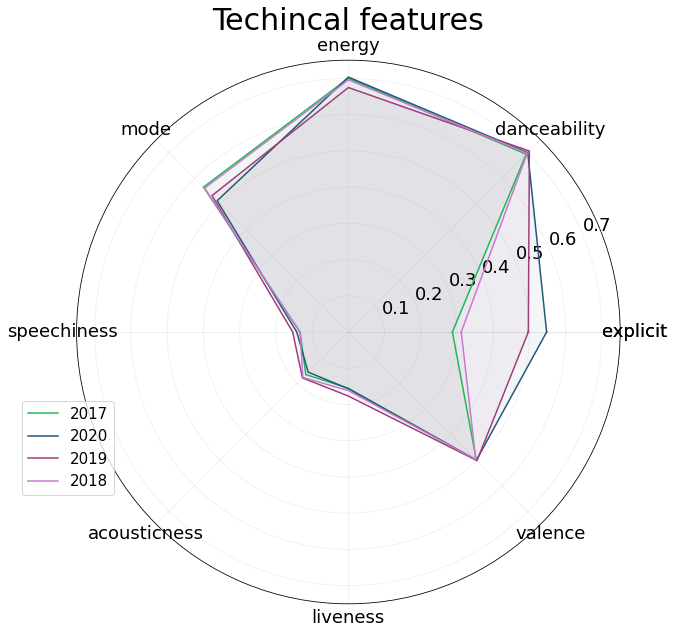

In [127]:
featuresToExtract = ["explicit", "danceability", "energy",
                     "mode", "speechiness", "acousticness", "liveness", "valence"]

plotter.plotResults(
    title="Techincal features",
    yArr=resultDF[featuresToExtract].to_numpy().tolist(),
    xTicks=featuresToExtract,
    legend=list(resultDF["year"]),
    yLim=[0, 0.75],
    style="polar",
    showGrid=True,
    fillPlot=True,
    legendLocation=[-0.1, 0.2],
    figSize=(10, 10),
)


#### Q4: Show technical features of tracks in the first 5 positions and in the last 5 positions of the TOP 100 Italy.

In [128]:
# Q4: Show technical features of tracks in the first 5 positions and in the last 5 positions of the TOP 100 Italy.

resultDF = executeQuery("""
    MATCH (t:Track)-[r:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country { id:"IT" })
    WHERE r.position <= 5
    RETURN
        "Top 5" AS type,
        AVG(toInteger(t.explicit)) as explicit,
        AVG(t.danceability) as danceability,
        AVG(t.energy) as energy,
        AVG(t.mode) as mode,
        AVG(t.speechiness) as speechiness,
        AVG(t.acousticness) as acousticness,
        AVG(t.liveness) as liveness,
        AVG(t.valence) as valence

    UNION

    MATCH (t:Track)-[r:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country { id:"IT" })
    WHERE r.position >= 95
    RETURN
        "Last 5" AS type,
        AVG(toInteger(t.explicit)) as explicit,
        AVG(t.danceability) as danceability,
        AVG(t.energy) as energy,
        AVG(t.mode) as mode,
        AVG(t.speechiness) as speechiness,
        AVG(t.acousticness) as acousticness,
        AVG(t.liveness) as liveness,
        AVG(t.valence) as valence 
""")

In [129]:
resultDF

,type,explicit,danceability,energy,mode,speechiness,acousticness,liveness,valence
0,Top 5,0.327363,0.715490,0.691974,0.534328,0.11331,0.166386,0.165313,0.562271
1,Last 5,0.365672,0.689251,0.678459,0.535655,0.13107,0.206534,0.166331,0.499405


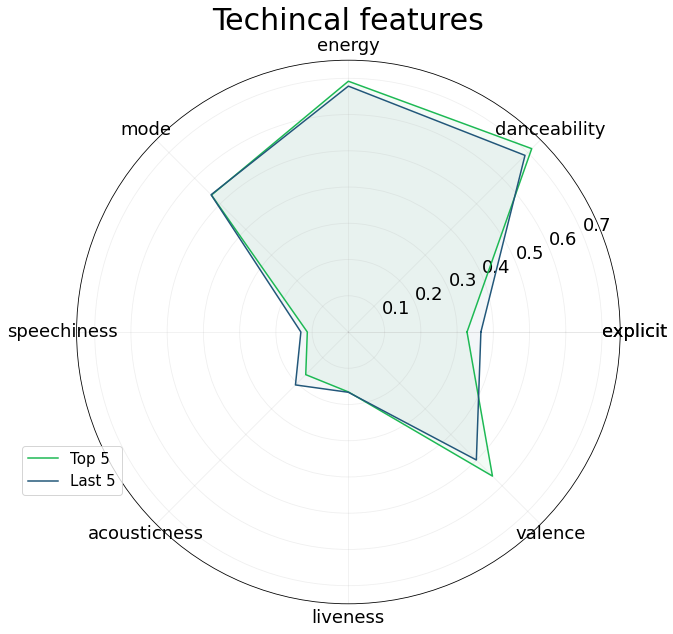

In [130]:
featuresToExtract = ["explicit", "danceability", "energy",
                     "mode", "speechiness", "acousticness", "liveness", "valence"]
                     
plotter.plotResults(
    title="Techincal features",
    yArr=resultDF[featuresToExtract].to_numpy().tolist(),
    xTicks=featuresToExtract,
    legend=list(resultDF["type"]),
    yLim=[0, 0.75],
    style="polar",
    showGrid=True,
    fillPlot=True,
    legendLocation=[-0.1, 0.2],
    figSize=(10, 10),
)

#### Q5: On average how many tracks from Italian artists are present in Top 100 Italy for each year? (Grafico a barre)

In [131]:
# Q5: On average how many tracks from italian artists are present in Top 100 Italy for each year?

avgItalianTracksDF = executeQuery("""
    MATCH (c1:Country { id:"IT" })<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country { id:"IT" })
    WITH ch, ch.date.year AS year, COUNT(DISTINCT t) as numTracks
    RETURN year, avg(numTracks) as avgNumTracks
    ORDER BY year
""")

In [132]:
avgItalianTracksDF


,year,avgNumTracks
0,2017,40.339623
1,2018,63.673077
2,2019,72.134615
3,2020,66.772727


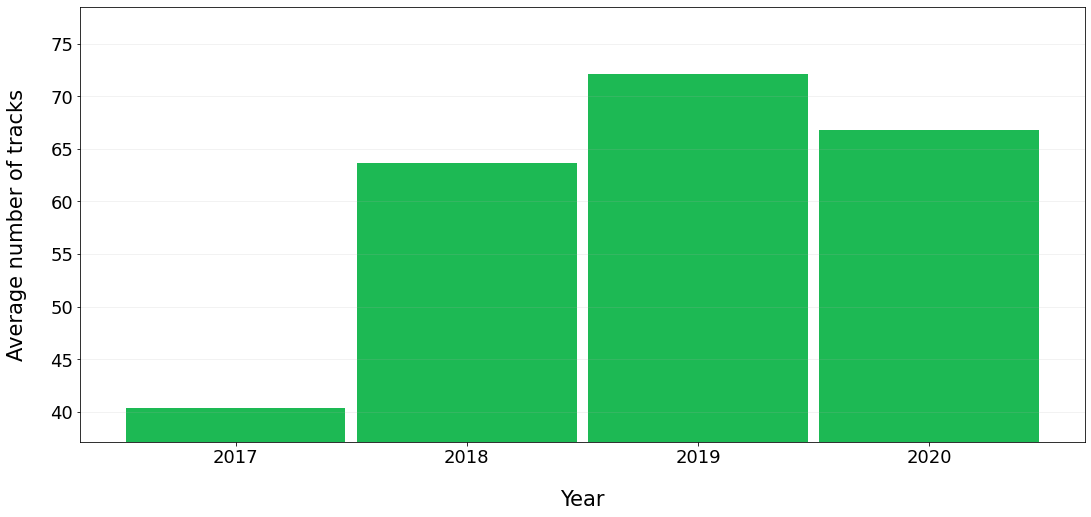

In [133]:
plotter.plotResults(
    x=np.arange(len(avgItalianTracksDF)),
    yArr=[list(avgItalianTracksDF["avgNumTracks"])],
    yLabel="Average number of tracks",
    xLabel="Year",
    xTicks=list(avgItalianTracksDF["year"]),
    showGrid=True,
    gridAxis="y",
    style="bar",
    saveTitle="query3"
)


As we can notice, in 2017 there were only 31 tracks on average in the TOP 100 Italy. We want to discovery if this is just a case of is there any reason behind this result.

So, in the next query we will check how many tracks were released by italian artist for each year.

#### Q6: How many tracks were released from Italian artist every year from 2017 to 2020 ?

In [134]:
# Q6: How many tracks were released from Italian artist every year from 2017 to 2020 ?

tracksReleasedDF = executeQuery("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPartOf]->(alb:Album)
    WHERE alb.releaseDate.year >= 2017
    WITH alb.releaseDate.year AS year, COUNT(DISTINCT t) as numTracks
    RETURN year, numTracks
    ORDER BY year
""")

In [135]:
tracksReleasedDF


,year,numTracks
0,2017,305
1,2018,431
2,2019,467
3,2020,425


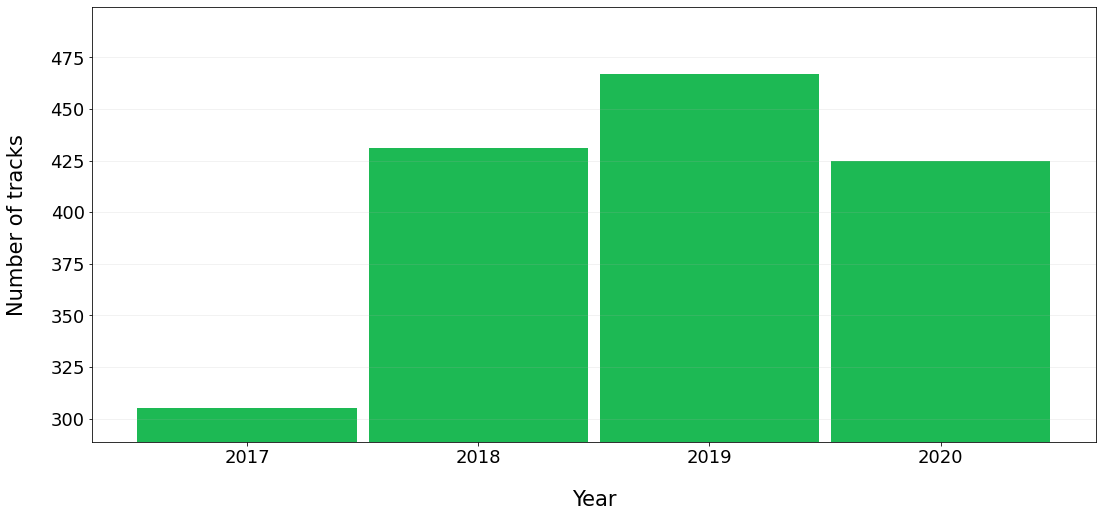

In [136]:
plotter.plotResults(
    x=np.arange(len(tracksReleasedDF)),
    yArr=[list(tracksReleasedDF["numTracks"])],
    yLabel="Number of tracks",
    xLabel="Year",
    xTicks=list(tracksReleasedDF["year"]),
    showGrid=True,
    gridAxis="y",
    style="bar",
    saveTitle="query4"
)

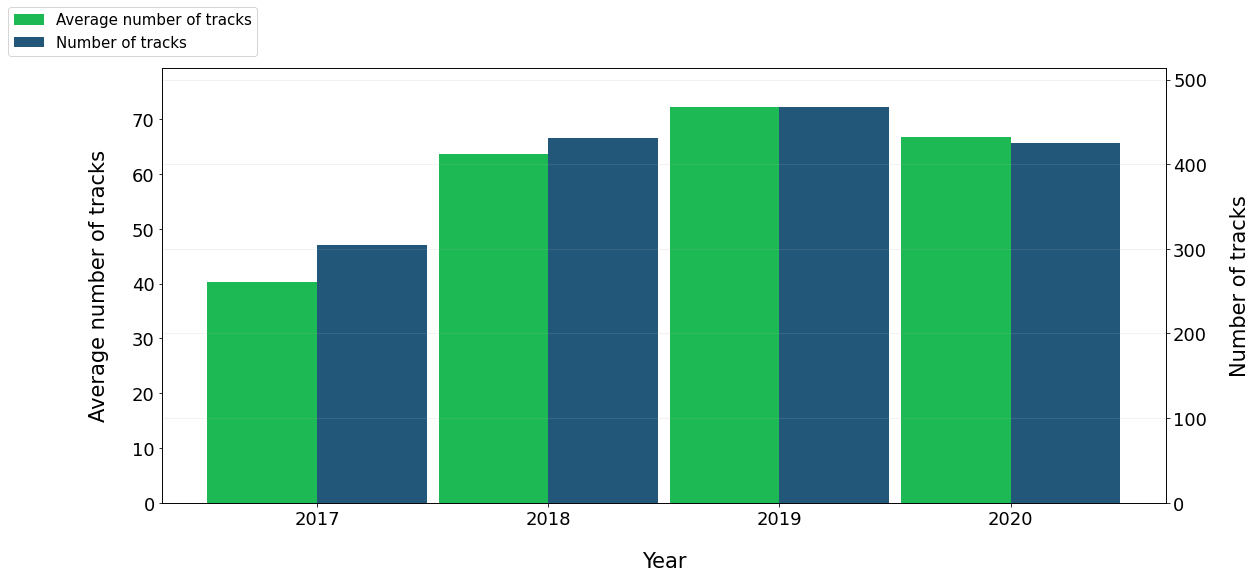

In [137]:
plotter.plotResults(
      x=np.arange(len(tracksReleasedDF)),
      yArr=[list(avgItalianTracksDF["avgNumTracks"]),
            list(tracksReleasedDF["numTracks"])],
      yLabel=["Average number of tracks", "Number of tracks"],
      xLabel="Year",
      yLim=[[0, np.max(list(avgItalianTracksDF["avgNumTracks"])) * 1.1],
            [0, np.max(list(tracksReleasedDF["numTracks"])) * 1.1]],
      legend=["Average number of tracks", "Number of tracks"],
      xTicks=list(tracksReleasedDF["year"]),
      showGrid=True,
      gridAxis="y",
      style="bar",
      twinIndexCut=0,
      saveTitle="query4.1"
)


Since in 2017 Italian artists relased only 163 tracks (almost half of 2018,2019 and 2020), it is understandable why in 2017 there were only 31 tracks on average in the TOP 100 Italy.

#### Q7: How many different Italian artist entered at least once in Top 100 Italy for each Year ? (Grafico a barre)

In [138]:
# Q7: How many different Italian artist entered at least once in Top 100 Italy for each Year ?

resultDF = executeQuery("""
    MATCH (c1:Country { id:"IT" })<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{ id:"IT" })
    RETURN ch.date.year AS year, COUNT(DISTINCT a) as numArtists
    ORDER BY year
""")

In [139]:
resultDF

,year,numArtists
0,2017,113
1,2018,113
2,2019,134
3,2020,150


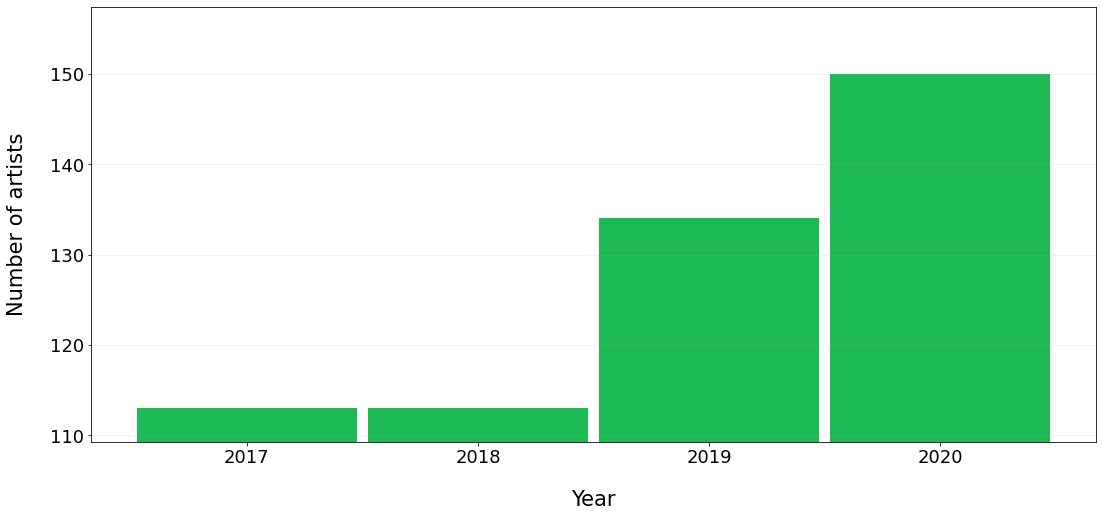

In [140]:
plotter.plotResults(
    x=np.arange(len(resultDF)),
    yArr=[list(resultDF["numArtists"])],
    yLabel="Number of artists",
    xLabel="Year",
    xTicks=list(resultDF["year"]),
    showGrid=True,
    gridAxis="y",
    style="bar",
    saveTitle="query5"
)

#### Q8: On average how many tracks from Italian artists are present in Top 100 Italy through the different months of the year ? (Grafico a linea)

In [141]:
# Q8: On average how many tracks from Italian artists are present in Top 100 Italy through the different months of the year ? 

resultDF = executeQuery("""
    MATCH (c1:Country { id:"IT" })<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country { id:"IT" })
    WITH ch,ch.date.month AS month, COUNT(DISTINCT t) as numTracks
    RETURN month, avg(numTracks) as avgNumTracks
    ORDER BY month
""")

In [142]:
resultDF

,month,avgNumTracks
0,1,54.294118
1,2,59.562500
2,3,57.333333
3,4,54.277778
4,5,59.411765
5,6,59.411765
6,7,60.777778
7,8,59.823529
8,9,63.388889
9,10,67.117647


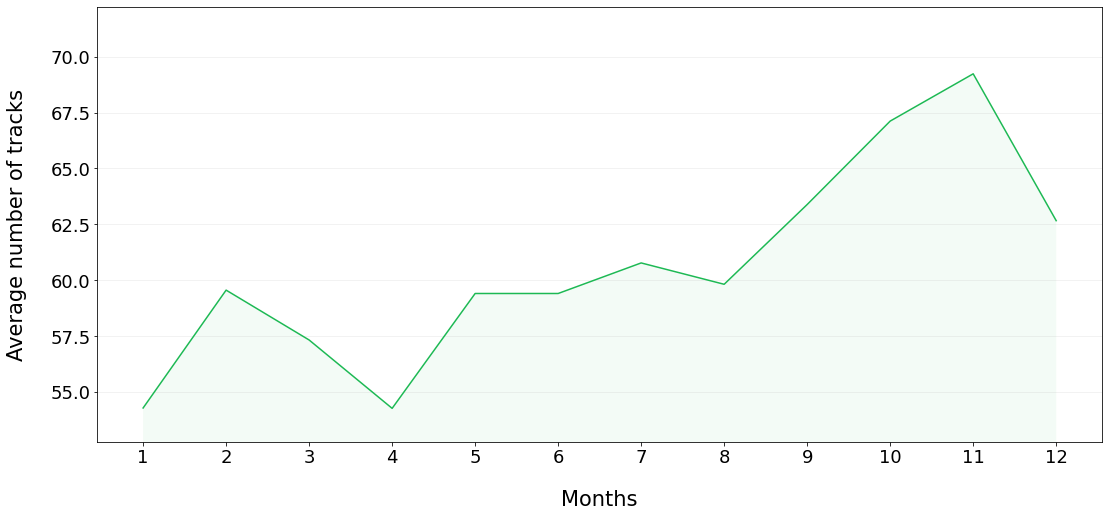

In [143]:
plotter.plotResults(
    x=np.arange(len(resultDF)),
    yArr=[list(resultDF["avgNumTracks"])],
    yLabel="Average number of tracks",
    xLabel="Months",
    xTicks=list(resultDF["month"]),
    showGrid=True,
    gridAxis="y",
    style="line",
    fillPlot=True,
    saveTitle="query6"
)

#### Q9: How many albums from Italian artists are released through the different months of the year ? (Grafico a linea)

In [144]:
#Q9: How many albums from Italian artists are released through the different months of the year ? 

resultDF = executeQuery("""
    MATCH (c1:Country { id:"IT" })<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(alb:Album)
    WITH alb.releaseDate.month AS month, COUNT(DISTINCT alb) as numAlbums
    RETURN month, numAlbums
    ORDER BY month
""")

In [145]:
resultDF

,month,numAlbums
0,1,73
1,2,110
2,3,59
3,4,43
4,5,87
5,6,82
6,7,34
7,8,17
8,9,56
9,10,73


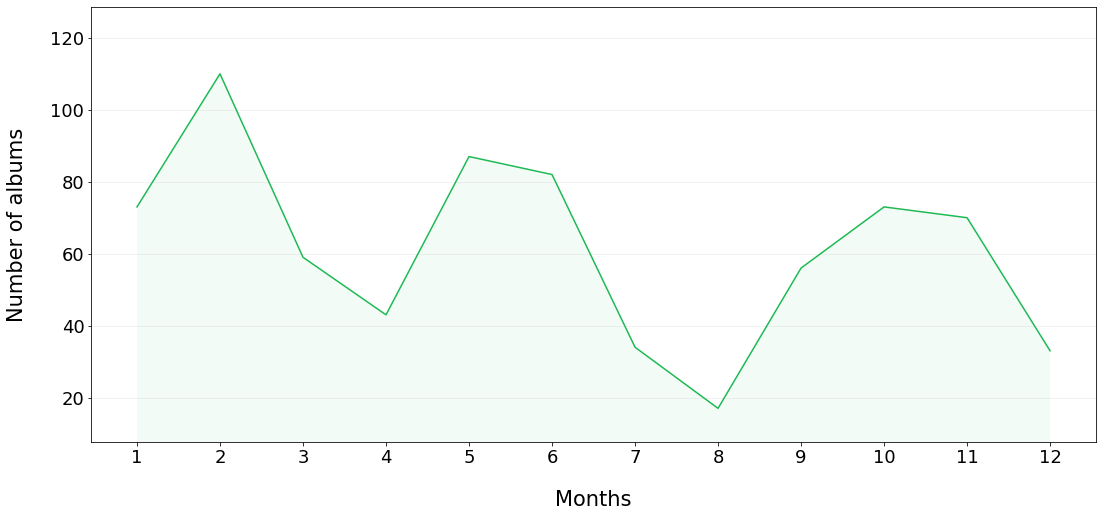

In [146]:
plotter.plotResults(
    x=np.arange(len(resultDF)),
    yArr=[list(resultDF["numAlbums"])],
    yLabel="Number of albums",
    xLabel="Months",
    xTicks=list(resultDF["month"]),
    showGrid=True,
    gridAxis="y",
    style="line",
    fillPlot=True,
    saveTitle="query7"
)

#### Q9: Who is the Italian artist with the highest number of tracks present in Top 100 Italy for each year? (Nomi degli artisti)

In [147]:
# Q9: Who is the Italian artist with the highest number of tracks present in Top 100 Italy for each year?

topArtistsDF = executeQuery("""
    MATCH (c1:Country { id:"IT" })<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country { id:"IT" })
    WITH a, ch.date.year AS year, COUNT(DISTINCT t) as numTracks
    ORDER BY numTracks DESC
    WITH year, COLLECT(a) AS artists, COLLECT(numTracks) as orderedNumTracks
    RETURN DISTINCT year, artists[0].id as artist, artists[0].name as artistName , orderedNumTracks[0] as numTracks
    ORDER BY year
""")

In [148]:
topArtistsDF

,year,artist,artistName,numTracks
0,2017,7F2utINZ6tSokSiZTQBE27,Guè,30
1,2018,5SulO4l40qDuV9zUGLZx7n,Capo Plaza,31
2,2019,0jdNdfi4vAuVi7a6cPDFBM,Lazza,35
3,2020,19i93sA0D7yS9dYoVNBqAA,tha Supreme,40


#### Q10: Show the distribution of the positions in the TOP 100 Italy reached by the just retrieved artist

In [149]:
# Q10: Show the distribution of the positions in the TOP 100 Italy reached by the just retrieved artist

positionsDF = executeQuery("""
    UNWIND $datas as data
    MATCH (a:Artist { id: data.artist })-[:partecipateIn]->(t:Track)-[r:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country { id:"IT" })
    WHERE ch.date >= date({year: data.year, month: 1, day: 1}) AND ch.date <= date({year: data.year, month: 12, day: 31})
    RETURN a.name as artist, COLLECT(r.position) AS positions
""", datas=[{"artist": x["artist"], "year": x["year"]} for _, x in topArtistsDF.iterrows()])

In [150]:
positionsDF

,artist,positions
0,Guè,"[65, 99, 86, 84, 74, 79, 85, 70, 68, 81, 79, 8..."
1,Capo Plaza,"[32, 100, 77, 62, 63, 73, 69, 68, 73, 85, 71, ..."
2,Lazza,"[58, 77, 85, 85, 87, 72, 70, 69, 54, 52, 37, 3..."
3,tha Supreme,"[32, 98, 91, 91, 92, 72, 74, 62, 64, 50, 52, 4..."


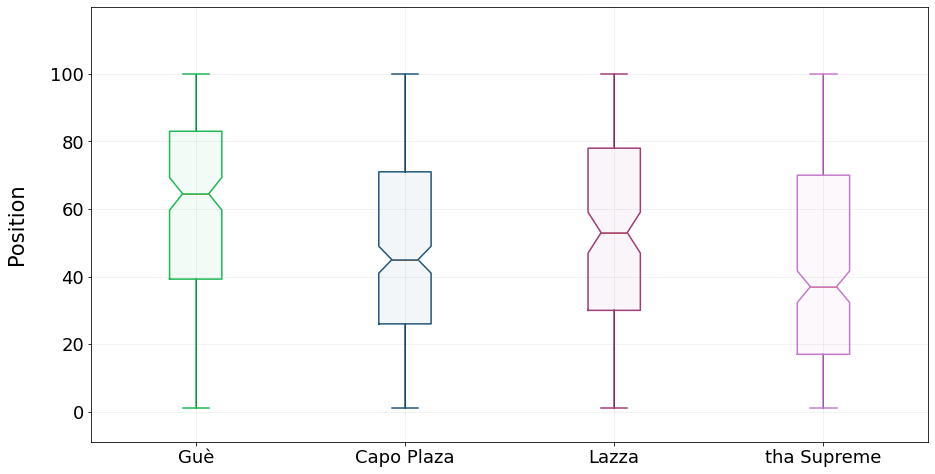

In [151]:
plotter.plotResults(
    yArr=list(positionsDF["positions"]),
    style="boxplot",
    fillPlot=True,
    figSize=(15, 8),
    yLabel="Position",
    showGrid=True,
    xTicks=list(positionsDF["artist"])
)

####  Q11: Show the top 3 Italian artists with the highest number of tracks present in Top 100 Italy at the same time.

In [152]:
# Q11: Show the top 3 Italian artists with the highest number of tracks present in Top 100 Italy at the same time.

topArtitstDF = executeQuery("""
    MATCH (c1:Country{id:"IT"})<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country{id:"IT"})
    WITH a,ch, COUNT(DISTINCT t) as numTracks
    ORDER BY numTracks DESC
    WITH a,COLLECT(ch) AS charts, COLLECT(numTracks) as orderedNumTracks
    RETURN DISTINCT a.id as artist, a.name as artistName, charts[0].date as date, charts[0].name as chart, orderedNumTracks[0] as numTracks
    LIMIT 3
""")

topArtitstDF

,artist,artistName,date,chart,numTracks
0,19i93sA0D7yS9dYoVNBqAA,tha Supreme,2019-11-24,TOP 100 Italy,24
1,1AgAVqo74e2q4FVvg0xpT7,Tedua,2020-06-14,TOP 100 Italy,21
2,5AZuEF0feCXMkUCwQiQlW7,Marracash,2019-11-17,TOP 100 Italy,19


The numbers of tracks present simultaneously in the TOP 100 Italy are quite high (24,19 and 18). 

We want to check if these artists released an album on the same month (or previous one) of the chart in which they have the highest number of tracks.

In [153]:
executeQuery("""
    UNWIND $artistsAndAlbums as data
    MATCH (a:Artist { id: data.artist })-[:partecipateIn]->(alb:Album { albumType:"album" })
    WHERE alb.releaseDate >= date({ year: data.date.year, month: data.date.month - 1, day: 1 })
        AND alb.releaseDate <= date({ year: data.date.year, month: data.date.month, day: 30 })
    RETURN a.name as artist, alb.name as albumName, alb.releaseDate as releaseDate
""", artistsAndAlbums=[{"artist": x["artist"], "date": x["date"]} for _, x in topArtitstDF.iterrows()])


,artist,albumName,releaseDate
0,tha Supreme,23 6451,2019-11-15
1,Tedua,"Vita Vera - Mixtape, aspettando la Divina Comm...",2020-06-12
2,Tedua,Vita Vera Mixtape,2020-06-05
3,Marracash,Persona,2019-10-31


So, these Italian artists managed to have a lot of tracks in the TOP 100 Italy at the same time, because they released albums whose tracks probably entered all in TOP 100 Italy.

#### Q12: Show the youngest artist who entered in the first 10 positions of Top 100 Italy for each year.

In [154]:
# Q12: Show the youngest artist who entered in the first 10 positions of Top 100 Italy for each year.

executeQuery("""
    MATCH (c1:Country { id:"IT" })<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[r:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country { id:"IT" })
    WHERE r.position <=10 AND p.birthDate IS NOT NULL
    WITH ch,a,p
    ORDER BY p.birthDate DESC
    WITH ch.date.year AS year, COLLECT(a.name) AS artistsNames, COLLECT(p.birthDate) AS artistsBirthDates
    RETURN year, artistsNames[0] as artist, artistsBirthDates[0] as birthDate
""")

,year,artist,birthDate
0,2020,Rondodasosa,2002-04-29
1,2018,Martina Attili,2001-07-11
2,2019,tha Supreme,2001-03-17
3,2017,Måneskin,2001-01-18


Of course in the case of ***Maneskin*** the birthDate is referred to the youngest member of the group.

### Italian tracks abroad

#### Q13: How many tracks from Italian artist are present in a Top 100 of a different country for each year (grafico barre)

In [155]:
# Q13: How many tracks from Italian artist are present in a Top 100 of a different country for each year

resultDF = executeQuery("""
    MATCH (c1:Country { id:"IT" })<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country)
    WHERE c2.id <> "IT"
    WITH ch.date.year AS year, COUNT(DISTINCT t) AS numItalianTracks
    RETURN year,numItalianTracks
    ORDER BY year
""")

In [156]:
resultDF

,year,numItalianTracks
0,2017,22
1,2018,26
2,2019,22
3,2020,45


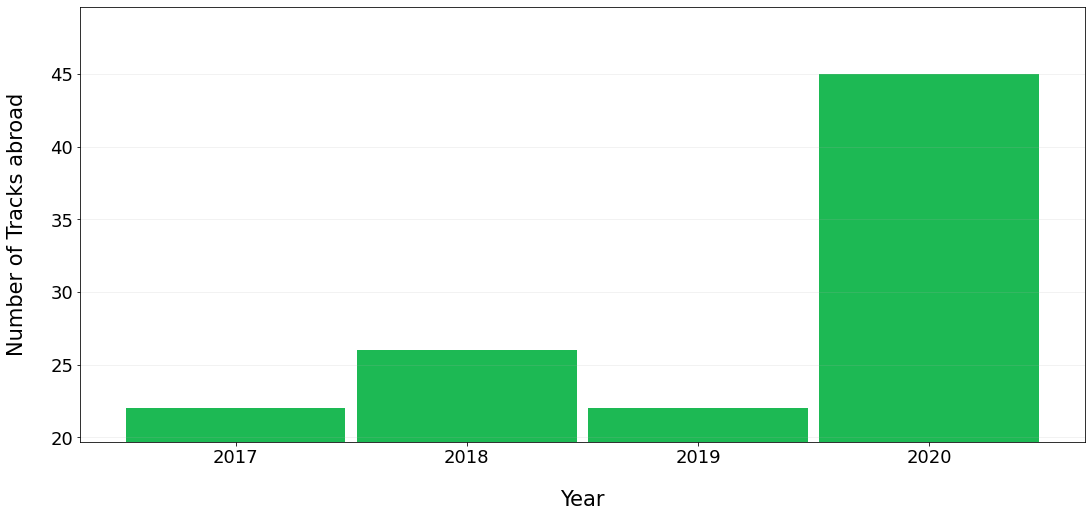

In [157]:
plotter.plotResults(
    x=np.arange(len(resultDF)),
    yArr=[list(resultDF["numItalianTracks"])],
    yLabel="Number of Tracks abroad",
    xLabel="Year",
    xTicks=list(resultDF["year"]),
    showGrid=True,
    gridAxis="y",
    style="bar",
    saveTitle="query11"
)

#### Q14: Show the countries that listen the most to Italian tracks. (show Names and numbers)

In [158]:
# Q14: Show the top 5 countries that listen the most to Italian tracks.

resultDF = executeQuery("""
    MATCH (c1:Country { id:"IT" })<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country)
    WHERE c2.id <> "IT"
    RETURN c2.id as countryCode, c2.name as countryName, COUNT(DISTINCT t) AS numItalianTracks
    ORDER BY numItalianTracks DESC
""")

resultDF

,countryCode,countryName,numItalianTracks
0,CH,Switzerland,37
1,DE,Germany,20
2,AT,Austria,19
3,NO,Norway,17
4,FR,France,13
5,SE,Sweden,13
6,BE,Belgium,10
7,NL,Netherlands,10
8,PL,Poland,10
9,ES,Spain,10


In [159]:
import plotly.express as px

fig = px.choropleth(resultDF,
                    locations="countryName",
                    locationmode='country names',
                    color="numItalianTracks",
                    hover_name="countryName",
                    color_continuous_scale='tealgrn')

fig.show()

#### Q15: Who is the artist present in the highest number of TOP 100 of different countries? Show also the countries in which he/she is present.

In [160]:
# Q13: Who is the artist present in the highest number of different countries? Show also the countries in which he/she is present.

executeQuery("""
    MATCH (c1:Country { id:"IT" })<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country)
    WHERE c2.id <> "IT"
    RETURN a.name as artist, COUNT(DISTINCT c2) AS numCountries, COLLECT(DISTINCT ch.name) AS charts
    ORDER BY numCountries DESC
    LIMIT 1
""")

,artist,numCountries,charts
0,Gigi D'Agostino,30,"[TOP 100 Austria, TOP 100 Poland, TOP 100 Germ..."


#### Q15: Who is the artist with the highest number of tracks present oustide Italy ? Show also the names of the tracks. 

In [161]:
# Q15: Who is the artist with the highest number of tracks present oustide Italy ? Show also the names of the tracks. 

executeQuery("""
    MATCH (c1:Country { id:"IT" })<-[:hasNationality]-(p:Person)-[:isMemberOf]->(a:Artist)-[:partecipateIn]->(t:Track)-[:isPositionedIn]->(ch:Chart)-[:isReferredTo]->(c2:Country)
    WHERE c2.id <> "IT"
    RETURN a.name as artist, COUNT(DISTINCT t) AS numTracks, COLLECT(DISTINCT t.name) as trackNames
    ORDER BY numTracks DESC
    LIMIT 1
""")

,artist,numTracks,trackNames
0,Sfera Ebbasta,12,"[Dracula, Bottiglie Privè, McQueen, Happy Birt..."


We have shown that actually there are two different criteria to determine the most "widespread" Italian artist abroad:

**1)** Count how many different countries the artist has reached excluding Italy. In this case, the best is ***Gigi D'Agostino***


**2)** Count the total number of tracks present in countries outside Italy. In this case, the best is ***Sfera Ebbasta***